In [1]:
from pathlib import Path
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from tqdm import tqdm
from scipy.stats import zscore

root = "C://Users//Josh Selfe//OneDrive - Nexus365//Other Documents//Neuromatch"

sup_bef = 'VR2_2021_03_20_1' #example mouse before supervised learning
sup_aft = 'VR2_2021_04_06_1' #example mouse after supervised learning
unsup_bef = 'TX105_2022_10_08_2' #example mouse before supervised learning
unsup_aft = 'TX105_2022_10_19_2' #example mouse after supervised learning
sup_test1 = 'VR2_2021_04_11_1' #example mouse after supervised learning, test 1

In [2]:
def dprime(x1, x2):
    """x1,x2: neurons * frames """
    u1, u2 = np.nanmean(x1, 1), np.nanmean(x2, 1)
    sig1, sig2 = np.nanstd(x1, 1), np.nanstd(x2, 1)
    return 2 * (u1 - u2) / (sig1 + sig2)  

In [8]:
def neu_area_ID(iarea):
    area_name = ['V1', 'mHV', 'lHV', 'aHV']
    idx = {}
    for ar in area_name:
        if ar=='V1':
            idx[ar] = iarea==8
        elif ar=='mHV':
            idx[ar] = (iarea==0) | (iarea==1) | (iarea==2) | (iarea==9)
        elif ar=='lHV':
            idx[ar] = (iarea==5) | (iarea==6)
        elif ar=='aHV':
            idx[ar] = (iarea==3) | (iarea==4)     
    return idx

def load_retino(root = ''):
    """return: dtrans, areasN, ix, ix_area"""
    dtrans = np.load(os.path.join(root, 'VR2_2021_04_11_trans.npz'), allow_pickle=True)
    areasN = ['All','V1','medial','anterior','lateral']
    ix = neu_area_ID(dtrans['iarea'])    
    out = {'xy_t':dtrans['xy_t'], 'iarea':dtrans['iarea'], 'ar_name':areasN, 'neu_ar_idx':ix}
    return out

In [4]:
# read behavioural variables in 

Beh_test_1 = np.load(os.path.join(root, 'Beh_sup_test1.npy'), allow_pickle=1).item()
beh = Beh_test_1 ['VR2_2021_04_11_1']

ntrials = beh['ntrials'] # number of trials
WallName = beh['WallName'] # name of wall for each frame
cum_pos_fr = beh['ft_PosCum'] # cumulative position in decimeters for each frame

RewPos = beh['RewPos'] # position of reward in corridor
SoundPos = beh['SoundPos'] # position of sound cue in corridor 



In [5]:
# read neural data in and go from PCA space back to neural space
svd_dec_400pc = np.load(os.path.join(root, sup_test1 +'_SVD_dec.npy'), allow_pickle=1).item() # 400 PCs
spks = svd_dec_400pc['U'][:, :].T @ svd_dec_400pc['V'] # project from the PC space back to neural space (only do it for the first 1000 neuorns)

#spks = zscore(spks, axis=1) 

c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


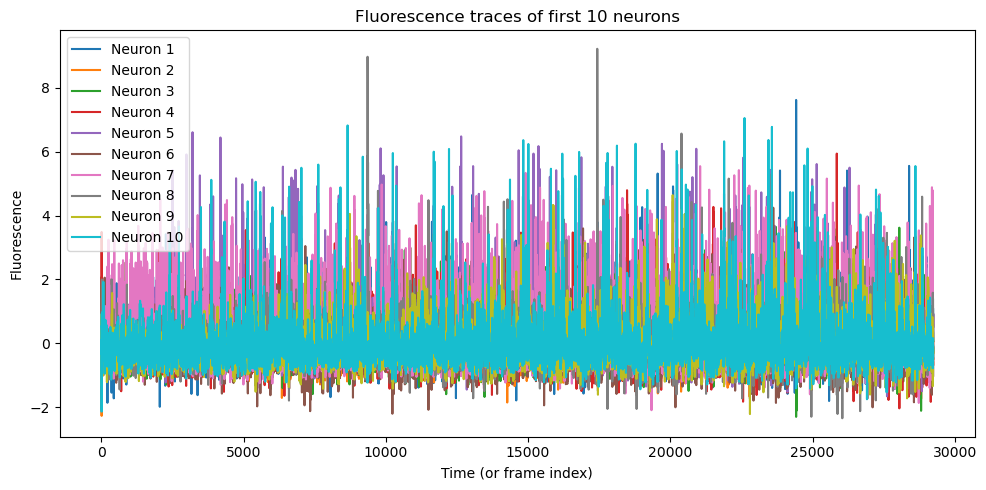

In [4]:
# plot some neurons for sanity check
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(spks[i], label=f'Neuron {i+1}')

plt.xlabel("Time (or frame index)")
plt.ylabel("Fluorescence")
plt.title("Fluorescence traces of first 10 neurons")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# interpolate into neurons*trials*decimeters
from scipy import interpolate
import pdb;
nfrs = spks.shape[1] # number of frames
def interp_value(v, vind, tind):
    """v: value; vind: index; tind: target index"""
    #pdb.set_trace()
    Model_ = interpolate.interp1d(vind, v, fill_value='extrapolate')
    return Model_(tind)

max_cum_pos = ntrials * 60 # length of corrior is 60 decimeters (6 meters)
interp_spk = np.empty((spks.shape[0], max_cum_pos))
for i in range(spks.shape[0]):
    interp_spk[i] = interp_value(spks[i], cum_pos_fr[:nfrs], np.arange(max_cum_pos))
interp_spk = interp_spk.reshape((interp_spk.shape[0], ntrials, 60))

c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\scipy\interpolate\_interpolate.py:500: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [9]:
# zhong et al get_reward_neuorns
aHV = load_retino(root = root)['neu_ar_idx']['aHV']

u_spk = interp_spk[:, :, 5:40].mean(2) # take mean activity within texture area, starting from 5 (0.5 meter)

SoundFr = beh['SoundFr'].astype(int)
Pos = np.mod(beh['SoundDelPos'], beh['Corridor_Length']) # reward positions and cue positions are highly correlated in reward corridor
                                                            # since non-reward corridor doesn't have reward, so we use cue positions instead
u_pos = Pos.mean()
uniqW, WallN, isRew, ntrials = beh['UniqWalls'], beh['WallName'], beh['isRew'], beh['ntrials']
stim_id = beh['stim_id']
stim1 = WallN==uniqW[stim_id==2]
stim2 = WallN==uniqW[stim_id==0]

dp0 = dprime(spks[:, SoundFr[stim1]], spks[:, SoundFr[stim2]]) # equivilent to using all frames within the whole corridor
dp1 = dprime(u_spk[:, (Pos >= u_pos) & stim1 & isRew], u_spk[:, (Pos < u_pos) & stim1 & isRew])        
thr = np.percentile(dp1[aHV], 95) # dprime at 95 percentile in aHV
sel_idx = (dp0 >= 0.3) & (dp1 >= thr) & aHV

sel_spk = interp_spk[sel_idx,:,:] 

In [ ]:
np.save(os.path.join(root,"leaf1_trials.npy"), leaf1_trials) 

In [11]:
interp_spk_corridor = sel_spk [:, :, :40]
# get the trials for each wall type
leaf1_mask = WallName == 'leaf1'
leaf2_mask = WallName == 'leaf2'

# Extract trials along axis=1 (trial axis)
leaf1_trials = interp_spk_corridor[:, leaf1_mask, :]
leaf2_trials = interp_spk_corridor[:, leaf2_mask, :]

RewPosLeaf1 = RewPos[leaf1_mask]  # reward position for leaf1 trials
SoundPosLeaf1 = SoundPos[leaf1_mask]  # sound position for leaf1 trials
RewPosLeaf2 = RewPos[leaf2_mask]  # reward position for leaf2 trials
SoundPosLeaf2 = SoundPos[leaf2_mask]  # sound position for leaf2

In [45]:
leaf1_trials = zscore(leaf1_trials, axis=1) 
leaf2_trials = zscore(leaf2_trials, axis=1)

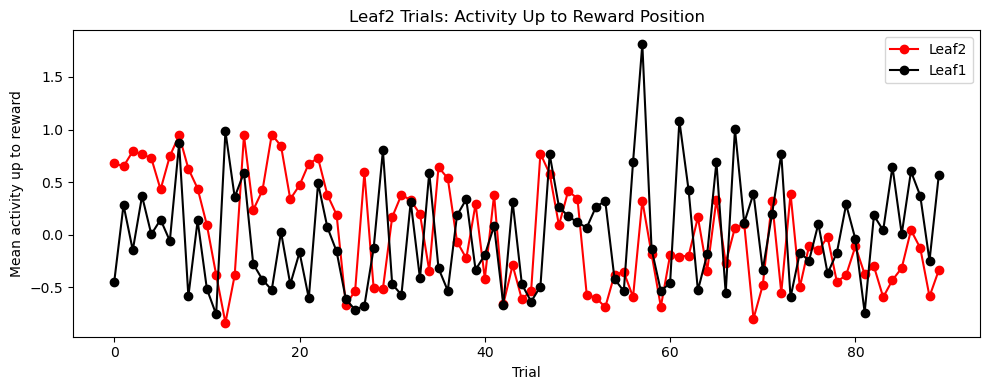

In [ ]:
# plot the average activity up to the reward position for leaf2 trials

mean_leaf2 = leaf2_trials.mean(axis=0)  
mean_leaf1 = leaf1_trials.mean(axis=0)
leaf1_indices = np.linspace(0, mean_leaf1.shape[0]-1, mean_leaf2.shape[0], dtype=int)
mean_leaf1 = mean_leaf1[leaf1_indices, :]  # align leaf1 to leaf2 trials
# Initialize result array
leaf2_means = np.zeros(mean_leaf2.shape[0])  # shape: (264,)
leaf1_means = np.zeros(mean_leaf1.shape[0])  # shape: (264,)
# Loop over trials and average up to reward position
for i in range(mean_leaf2.shape[0]):
    rewposleaf2 = int(RewPosLeaf2[i]) 
    rewposleaf1 = int(RewPosLeaf1[i])
    if rewposleaf2 > 0:
        leaf2_means[i] = mean_leaf2[i, :rewposleaf2].mean()
        leaf1_means[i] = mean_leaf1[i, :rewposleaf1].mean()
    else:
        print("S")
        leaf2_means[i] = np.nan  # or 0, if you prefer
        leaf1_means[i] = np.nan

# Plot
plt.figure(figsize=(10, 4))
plt.plot(leaf2_means, color='r', marker='o', label='Leaf2')
plt.plot(leaf1_means, color='k', marker='o', label='Leaf1')
plt.legend()
plt.xlabel("Trial")
plt.ylabel("Mean activity up to reward")
plt.title("Leaf2 Trials: Activity Up to Reward Position")
plt.tight_layout()
plt.savefig(os.path.join(root, "leaf1and2_trials_before_zscored.svg"), format='svg')
plt.show()

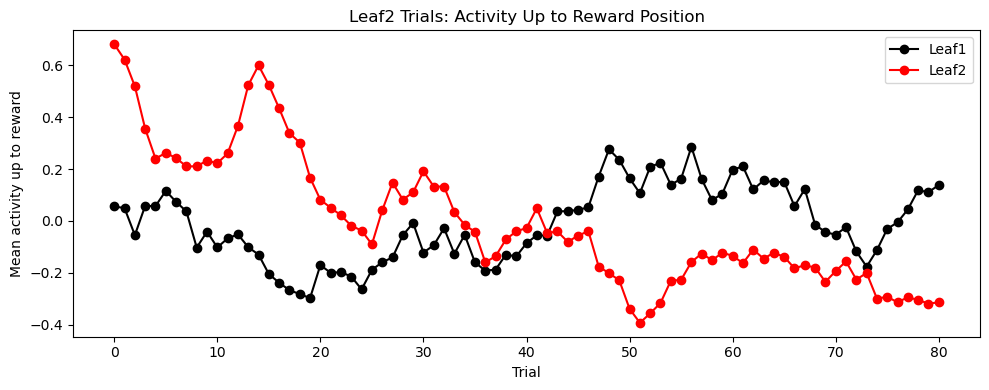

In [68]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed1 = moving_average(leaf1_means, window_size=10)
smoothed2 = moving_average(leaf2_means, window_size=10)

plt.figure(figsize=(10, 4))
plt.plot(smoothed1, color='k', marker='o', label='Leaf1')
plt.plot(smoothed2, color='r', marker='o', label='Leaf2')
plt.legend()
plt.xlabel("Trial")
plt.ylabel("Mean activity up to reward")
plt.title("Leaf2 Trials: Activity Up to Reward Position")
plt.tight_layout()
plt.savefig(os.path.join(root, "leaf1and2_trials_after_smoothed10_zscored.svg"), format='svg')
plt.show()

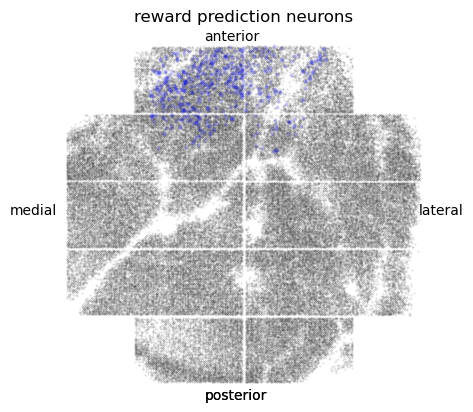

In [17]:
retin = np.load(os.path.join(root, 'VR2_2021_04_11_trans.npz'), allow_pickle=1) # load retinotopy information
xpos = retin['xpos']/0.75 # divided by pixel size (0.75) along x direction
ypos = retin['ypos']/0.5 # divided by pixel size (0.5) along y direction

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.axis('off')

plt.scatter(-ypos, xpos, c='k', s=0.1, alpha=0.2) # plot all neurons (use as background)
plt.scatter(-ypos[sel_idx], xpos[sel_idx], c='b', s=5, alpha=0.1, label='selective to stim1') # stim1 selective neurons

plt.text(-0.1, 0.5, 'medial', transform=ax.transAxes)
plt.text(0.95, 0.5, 'lateral', transform=ax.transAxes)
plt.text(0.4, 0.97, 'anterior', transform=ax.transAxes)
plt.text(0.4, 0, 'posterior', transform=ax.transAxes)
plt.text(0.4, 0, 'posterior', transform=ax.transAxes)
plt.title('reward prediction neurons')
plt.savefig(os.path.join(root, "Output", "reward_prediction_neurons.svg"), format='svg')
plt.show()

In [28]:
np.save(os.path.join(root,"SoundPosLeaf2.npy"), SoundPosLeaf2) 

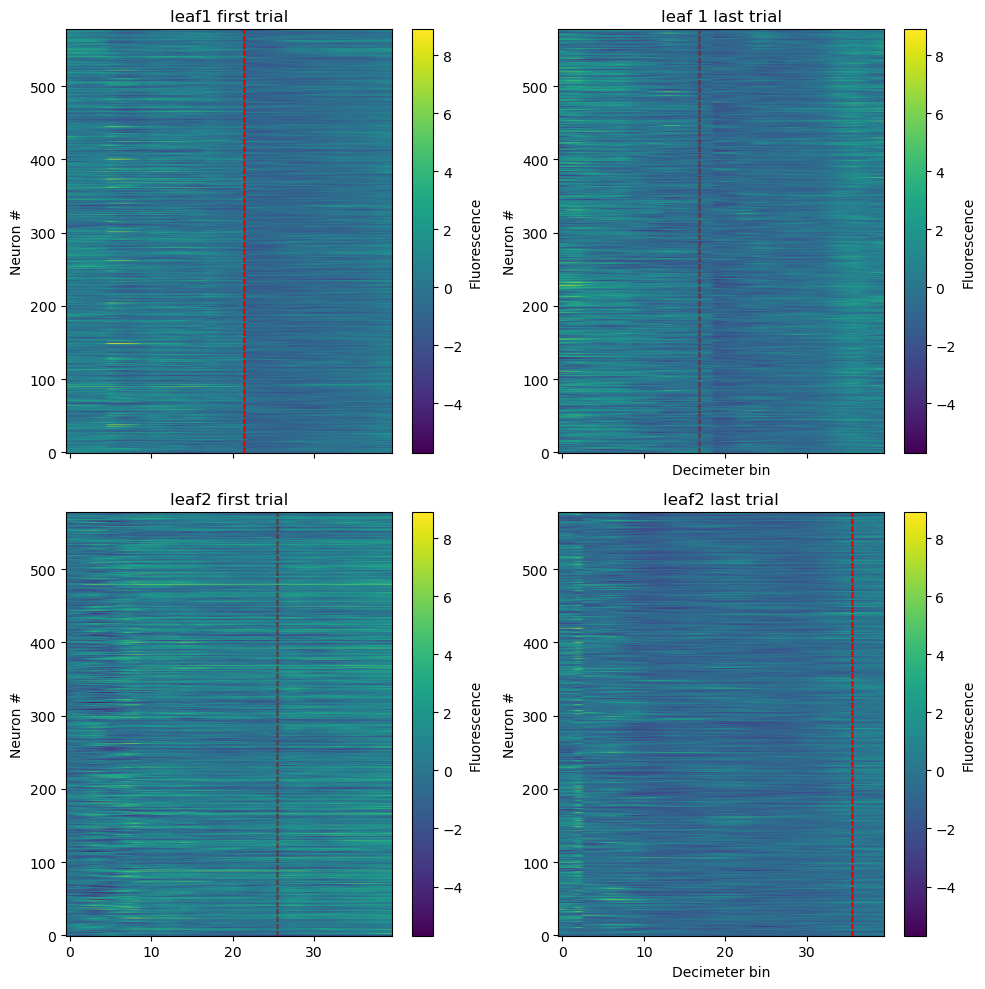

In [70]:
# Extract trial 1 (index 0) and trial 199 (index 198)
first = 0
last = -4  # -1 is the last trial, -2 is the second to last trial

leaf1_first = leaf1_trials[:, first, :]     
leaf1_last = leaf1_trials[:, last, :] 
leaf2_first = leaf2_trials[:, first, :]     
leaf2_last = leaf2_trials[:, last, :]  

vmin = min(leaf1_first.min(), leaf1_last.min(), leaf2_first.min(), leaf2_last.min())
vmax = max(leaf1_first.max(), leaf1_last.max(), leaf2_first.max(), leaf2_last.max())

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

im1 = axes[0, 0].imshow(leaf1_first, aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axes[0,0].set_title("leaf1 first trial")
axes[0,0].set_ylabel("Neuron #")
axes[0, 0].axvline(SoundPosLeaf1[first], color='k', linestyle='--', linewidth=1)
axes[0, 0].axvline(RewPosLeaf1[first], color='r', linestyle='--', linewidth=1)
plt.colorbar(im1, ax=axes[0,0], orientation='vertical', label='Fluorescence')

im2 = axes[0,1].imshow(leaf1_last, aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axes[0,1].set_title("leaf 1 last trial")
axes[0,1].set_ylabel("Neuron #")
axes[0,1].set_xlabel("Decimeter bin")
axes[0, 1].axvline(SoundPosLeaf1[last], color='k', linestyle='--', linewidth=1)
axes[0, 1].axvline(RewPosLeaf1[last], color='r', linestyle='--', linewidth=1)
plt.colorbar(im2, ax=axes[0,1], orientation='vertical', label='Fluorescence')

im3 = axes[1,0].imshow(leaf2_first, aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axes[1,0].set_title("leaf2 first trial")
axes[1,0].set_ylabel("Neuron #")
axes[1, 0].axvline(SoundPosLeaf2[first], color='k', linestyle='--', linewidth=1)
axes[1, 0].axvline(RewPosLeaf2[first], color='r', linestyle='--', linewidth=1)
plt.colorbar(im3, ax=axes[1,0], orientation='vertical', label='Fluorescence')

im4 = axes[1,1].imshow(leaf2_last, aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
axes[1,1].set_title("leaf2 last trial")
axes[1,1].set_ylabel("Neuron #")
axes[1,1].set_xlabel("Decimeter bin")
axes[1, 1].axvline(SoundPosLeaf2[last], color='k', linestyle='--', linewidth=1)
axes[1, 1].axvline(RewPosLeaf2[last], color='r', linestyle='--', linewidth=1)
plt.colorbar(im4, ax=axes[1,1], orientation='vertical', label='Fluorescence')

plt.tight_layout()
#plt.savefig(os.path.join(root, "Output", "example_trials_zs.svg"), format='svg')
plt.show()

In [72]:
# plot mean before and after the cue, for each neuron 
n_neurons, n_trials, n_bins = leaf1_trials.shape
activity_diff = []

for trial in range(n_trials):
    rew_pos = int(RewPosLeaf1[trial])

    # Mean across neurons
    before_activity = leaf1_trials[:, trial, :rew_pos].mean()
    after_activity  = leaf1_trials[:, trial, rew_pos:].mean()

    activity_diff.append(after_activity - before_activity)

activity_diff = np.array(activity_diff)

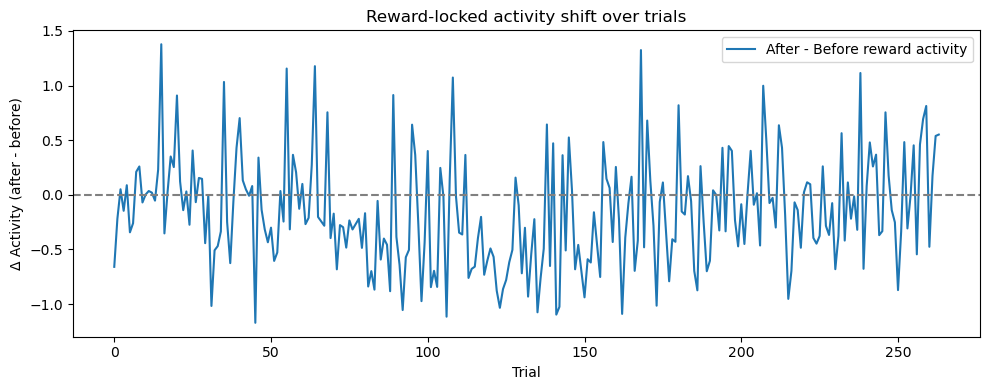

In [73]:
plt.figure(figsize=(10, 4))
plt.plot(activity_diff, label='After - Before reward activity')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Trial")
plt.ylabel("Δ Activity (after - before)")
plt.title("Reward-locked activity shift over trials")
plt.legend()
plt.tight_layout()
plt.show()